In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
import healpy as hp
import tqdm
import h5py
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
#mpl.rcParams['figure.figsize'] = (6, 4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
import h5py
import numpy as np

nside = 2
M = 10
C = 3
lengthscale = 0.3 # in units of magnitudes

# Load in data and format
with h5py.File('./rvs_grid.h5', 'r') as g:
    
    # Load data
    box = {k:v[:] for k,v in g.items()}
    print(box.keys())
    M_original, C_original = box['k'].shape[:2]
    
    # Calculate lengthscales in units of bins
    lengthscale_m = lengthscale/((box['phot_rp_mean_mag'][1]-box['phot_rp_mean_mag'][0])*(M_original/M))
    lengthscale_c = lengthscale/((box['bp_rp'][1]-box['bp_rp'][0])*(C_original/C))
    print('Lengthscales',lengthscale_m,lengthscale_c)


dict_keys(['bp_rp', 'healpix', 'k', 'n', 'phot_rp_mean_mag', 'rvs'])
Lengthscales 0.30000000000000104 0.3


# Test Hammer

In [3]:
# Import hammer
from SelectionFunctionHammer import Hammer
lmax = 4
hammer = Hammer(k = box['k'],
                n = box['n'],
                basis_options = {'lmax':lmax},
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [1.32824171, -2.97102361],
                file_root = f"lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}",
                )


100%|██████████| 25/25 [00:00<00:00, 4100.32it/s]

Spherical basis file does not exist, generating... (this may take some time!)
Spherical basis file loaded
10 10
3 3



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SelectionFunctionToolkit/StanModels/harmonic_magnitude_colour_position_sparse


81.00% sparsity
44.44% sparsity


In [ ]:
hammer.sigma

In [4]:
hammer.optimize(number_of_iterations=10000)

INFO:cmdstanpy:start chain 1


Running optimisation


INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 2.7 seconds
Convergence information stored in ./StanOutput/lmax4_nside2_M10_C3_l0.3_convergence.txt
Optimum values stored in ./StanOutput/lmax4_nside2_M10_C3_l0.3_results.h5


In [ ]:
hammer.print_convergence(number_of_lines=10)

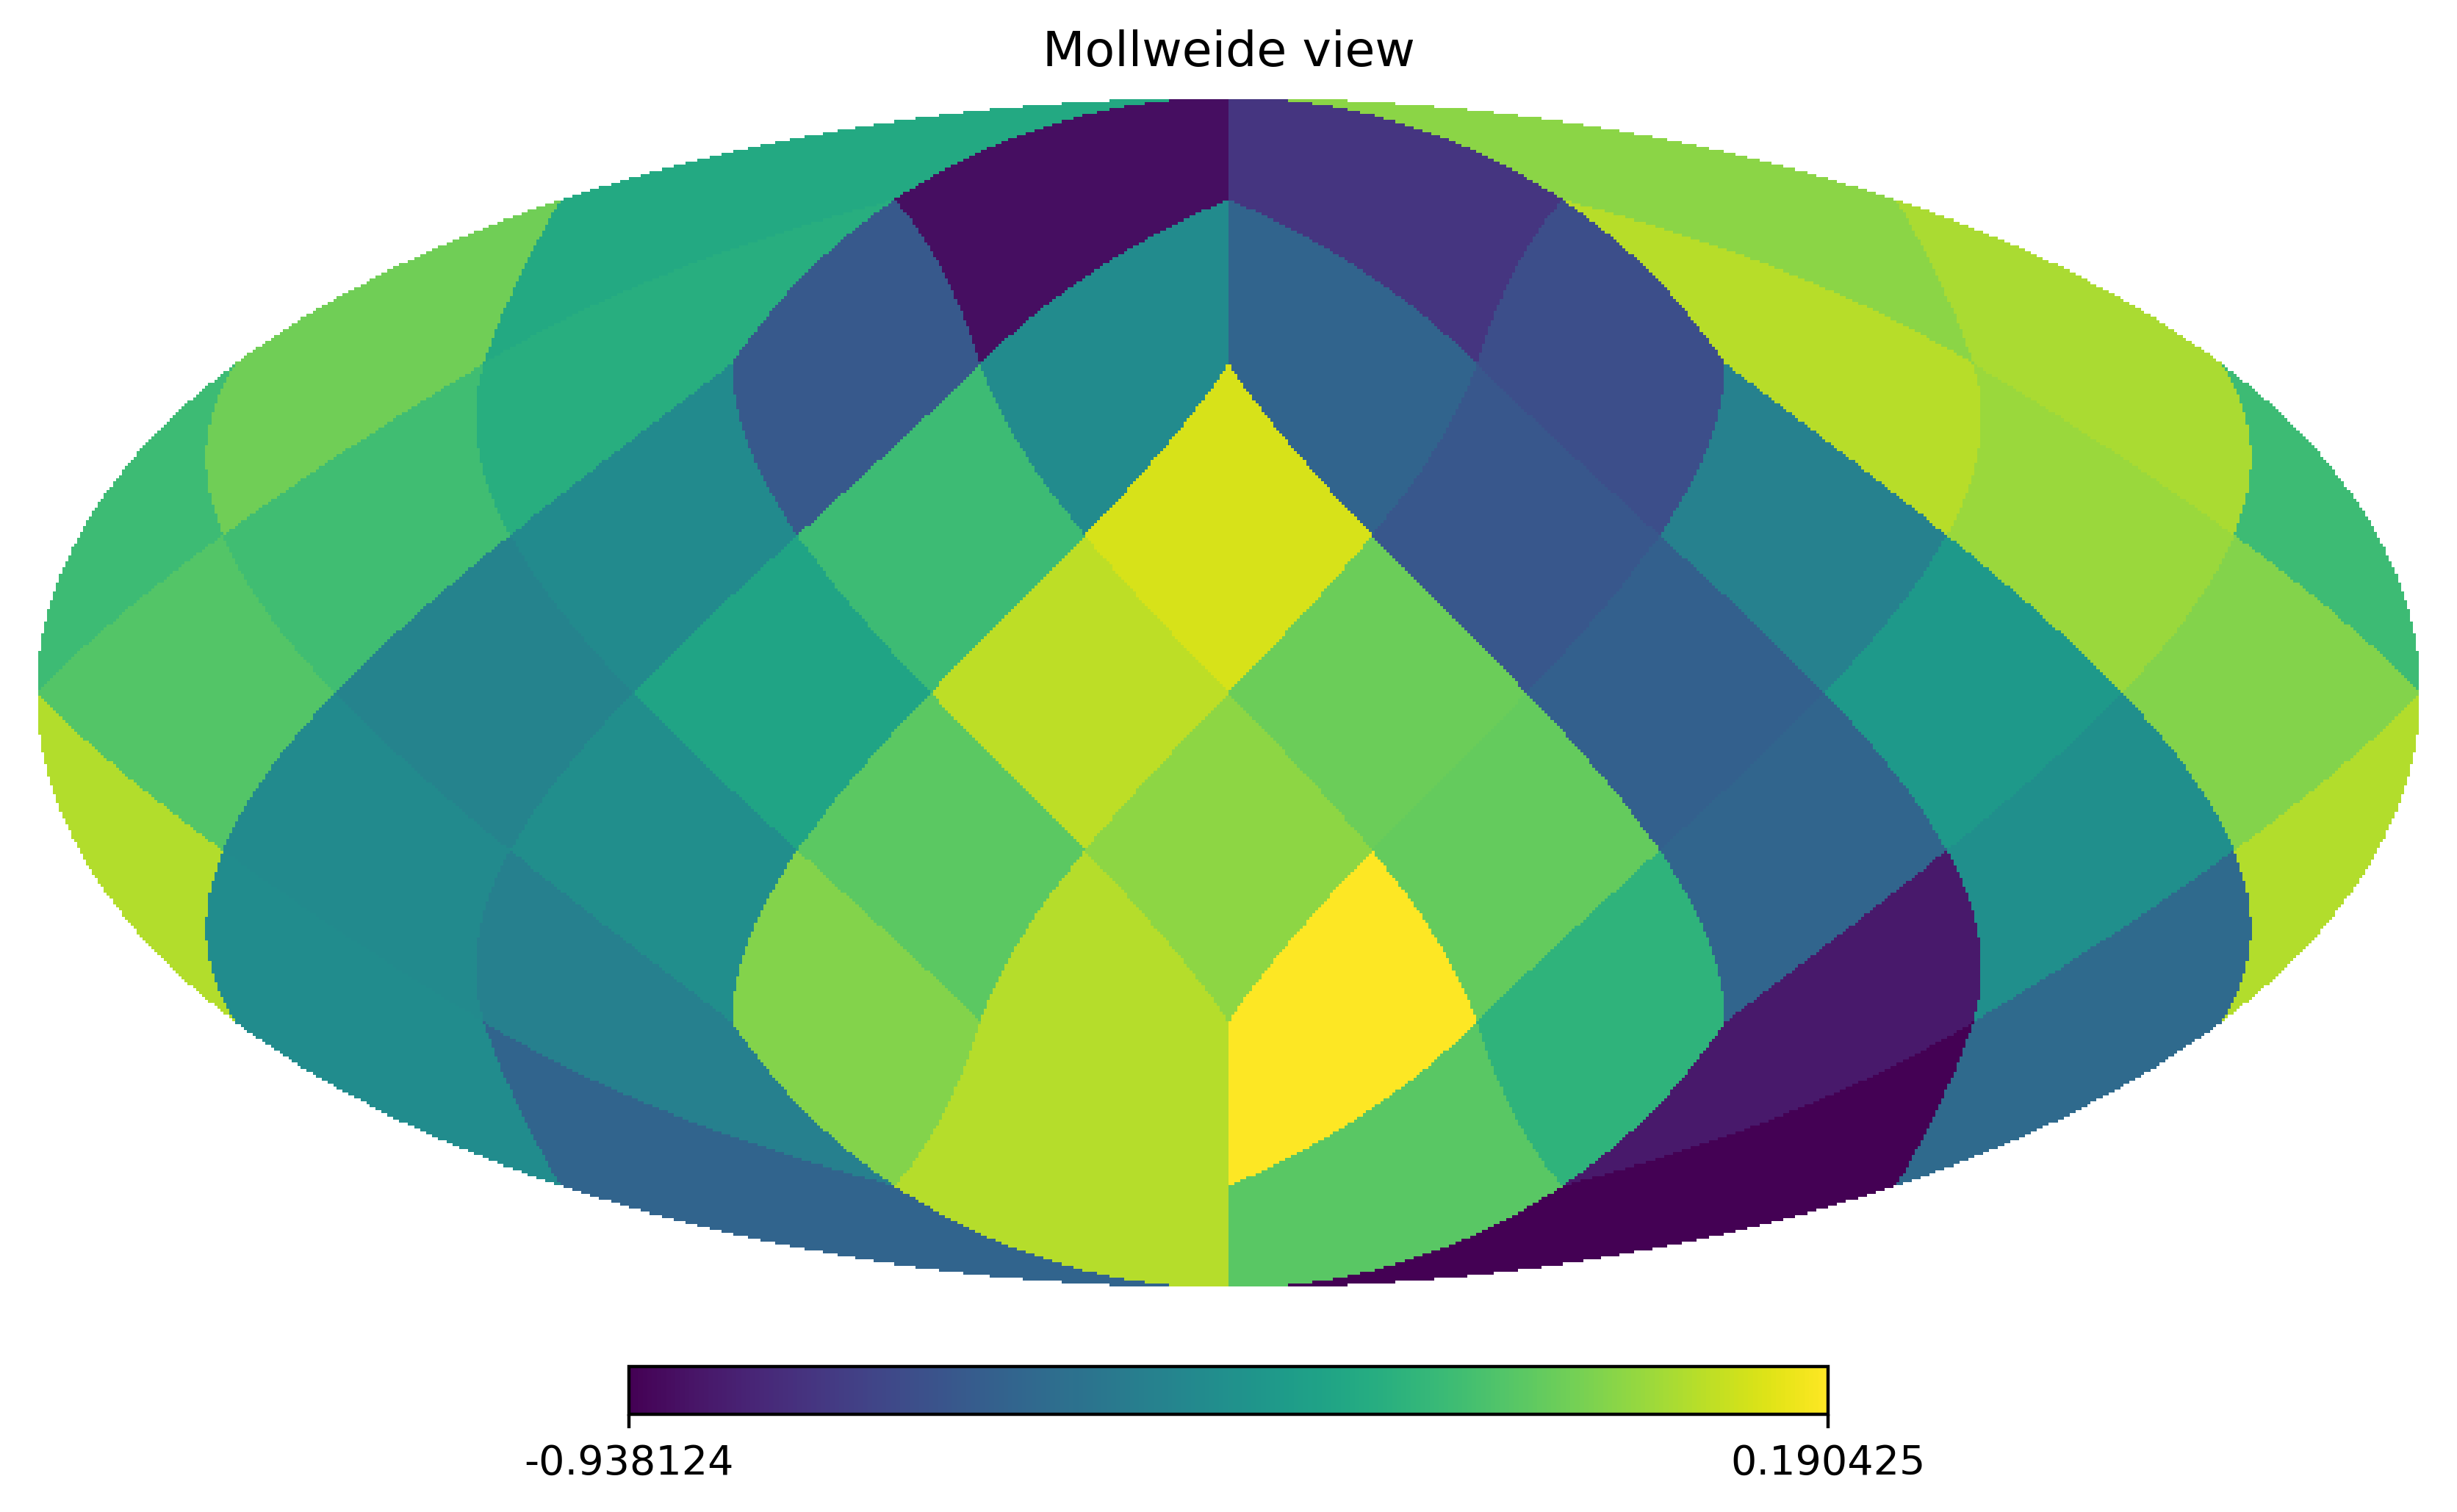

In [5]:
hp.mollview(hammer.optimum_x[0,0],nest=True)

# Test Chisel

In [37]:
# Import chisel
from SelectionFunctionChisel import Chisel
jmax = 1
B = 2.0
wavelet_tol = 1e-4
chisel = Chisel(k = box['k'],
                n = box['n'],
                basis_options = {'jmax':jmax,'B':B,'wavelet_tol':wavelet_tol},
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [1.32824171, -2.97102361],
                file_root = f"jmax{jmax}_B{B}_nside{nside}_M{M}_C{C}_l{lengthscale}",
                )


INFO:cmdstanpy:compiling stan program, exe file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None


Spherical basis file loaded
10 10
3 3


INFO:cmdstanpy:compiled model file: /Users/douglasboubert/Science/gaia-selection-function/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


81.00% sparsity
44.44% sparsity
wavelet_u
wavelet_v
cholesky_v_m
cholesky_u_m
cholesky_v_c
cholesky_u_c


In [17]:
from scipy import sparse
Y = np.array(sparse.csr_matrix((chisel.basis['wavelet_w'],chisel.basis['wavelet_v'],chisel.basis['wavelet_u'])).todense())

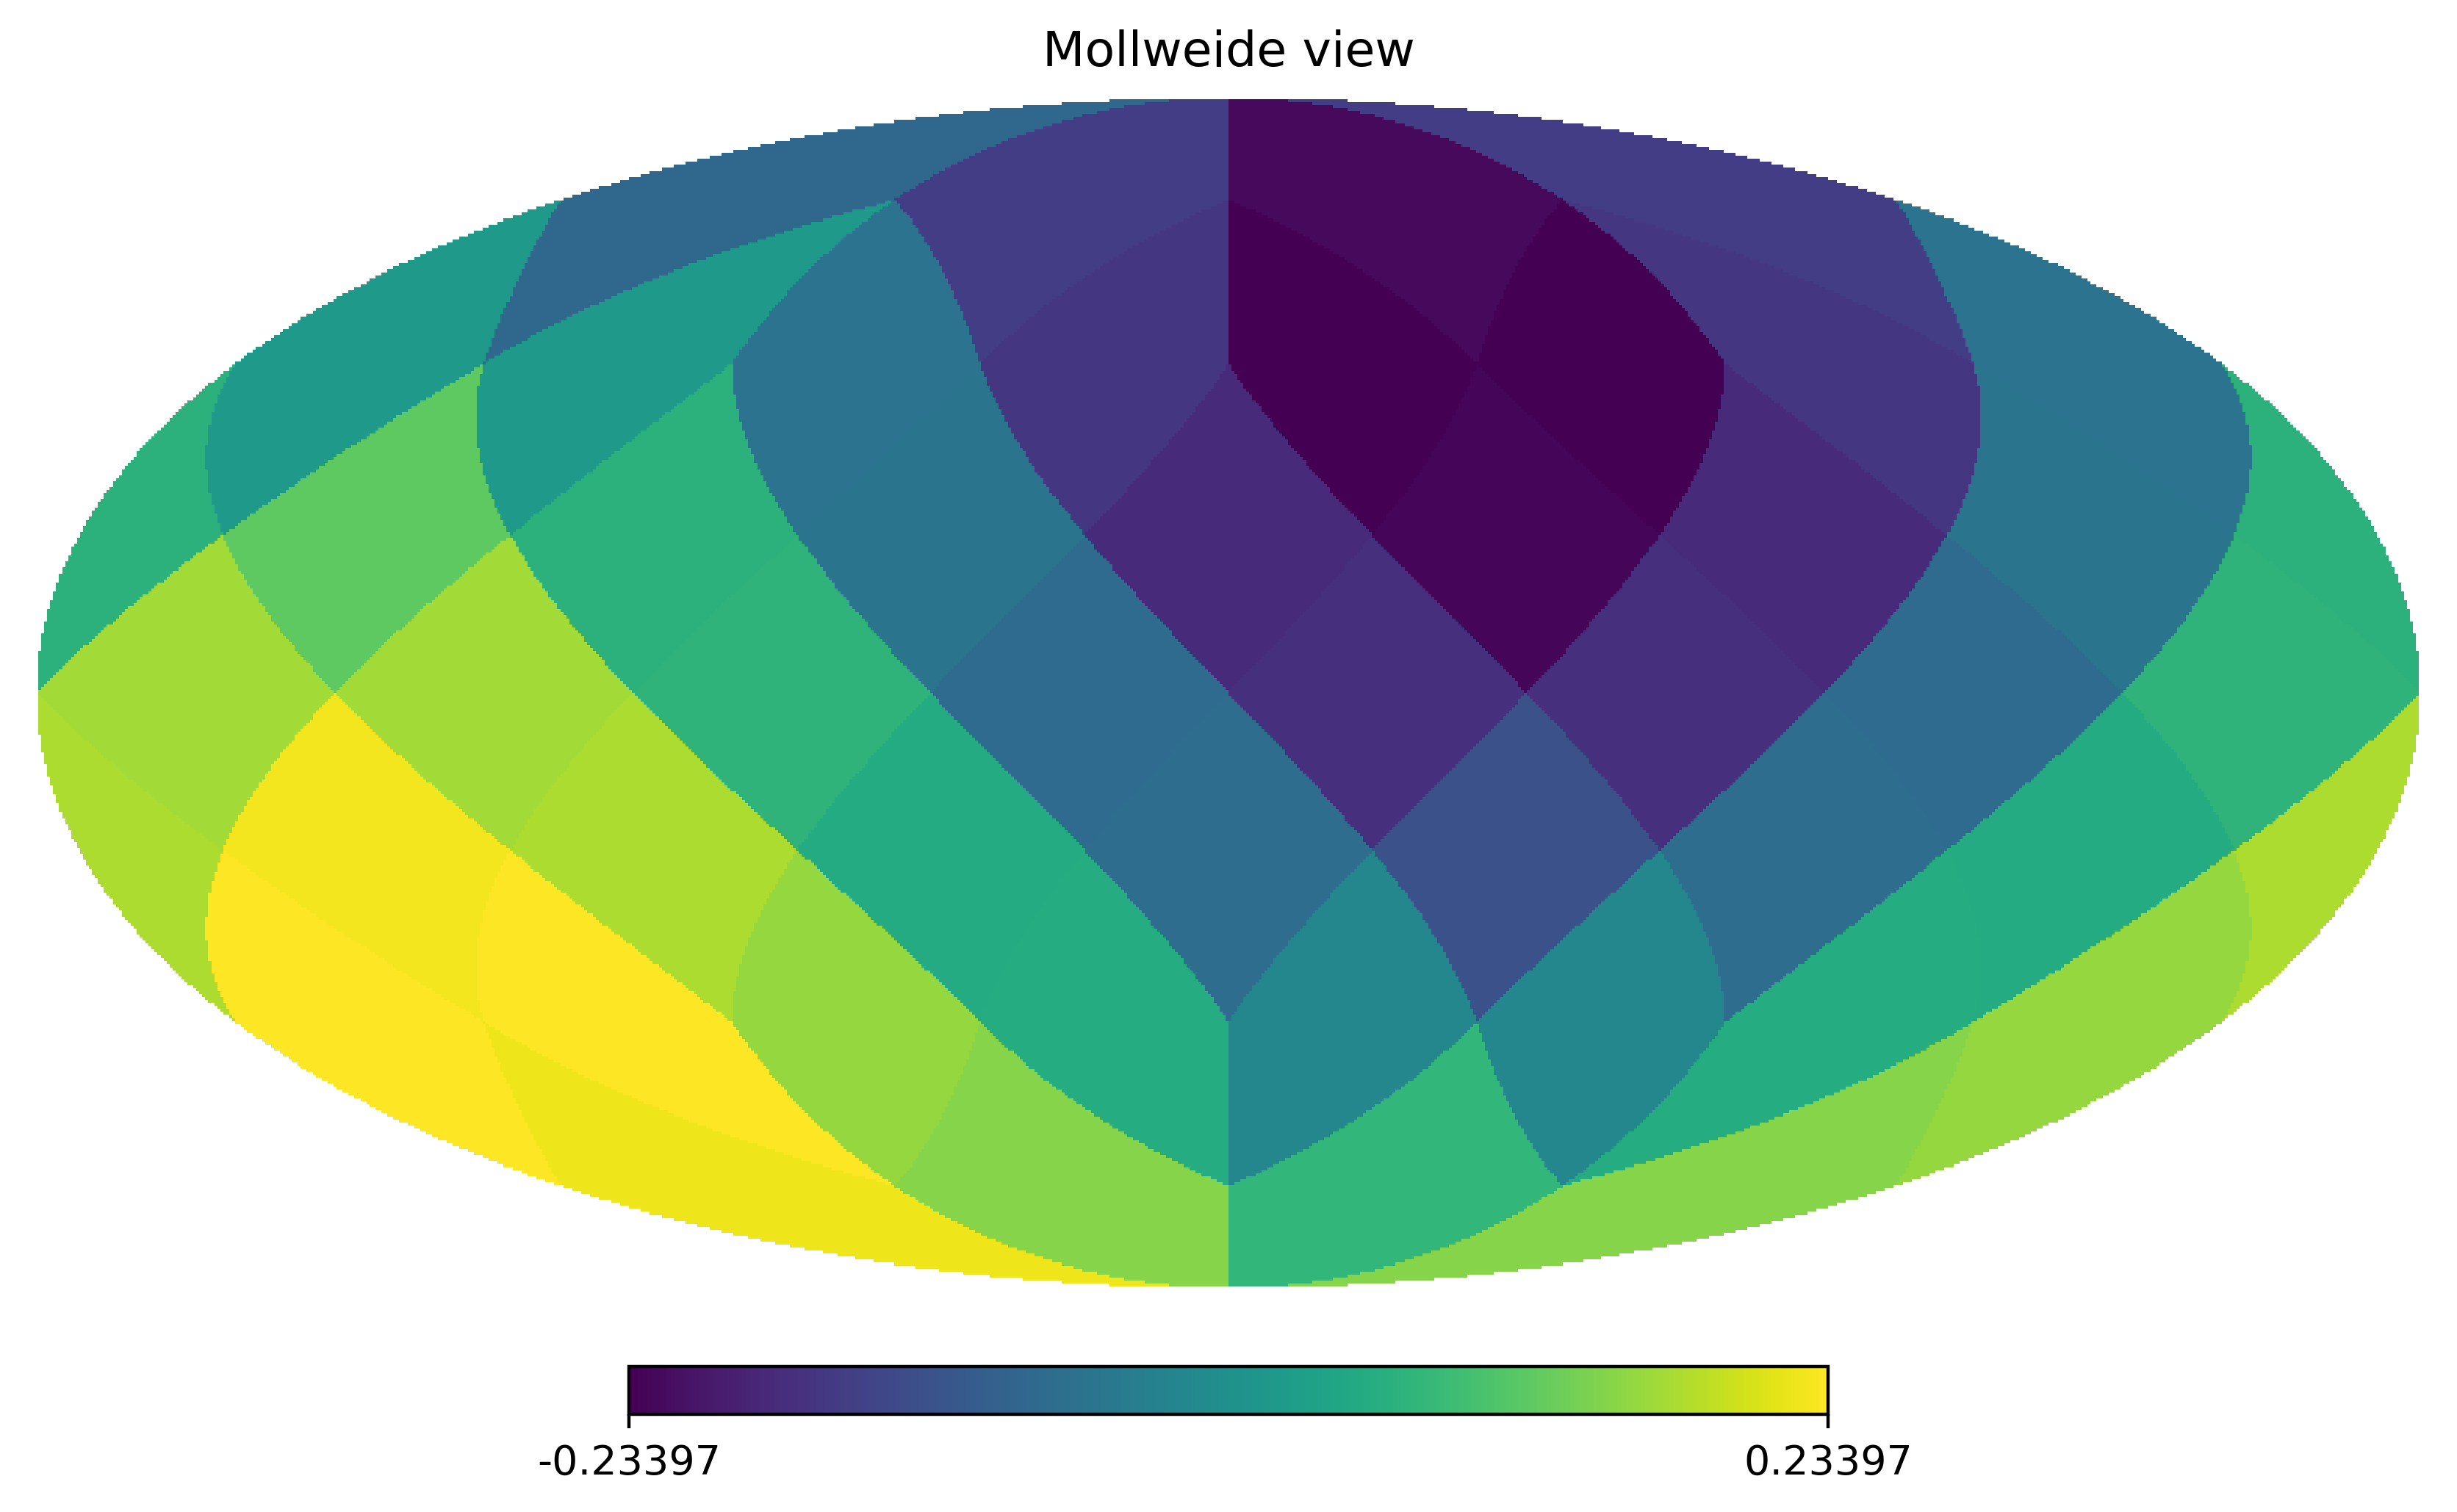

In [18]:
hp.mollview(Y[:,10])

In [38]:
chisel.optimize(number_of_iterations=10000,inits=0)

INFO:cmdstanpy:start chain 1


Running optimisation


INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 4.9 seconds
Convergence information stored in ./StanOutput/jmax1_B2.0_nside2_M10_C3_l0.3_convergence.txt
Optimum values stored in ./StanOutput/jmax1_B2.0_nside2_M10_C3_l0.3_results.h5


In [39]:
chisel.print_convergence(number_of_lines=10)

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

     899  -7.79145e+06     0.0952927        442.81           1           1      997   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

     999  -7.79119e+06     0.0183617       217.256      0.2566      0.2566     1103   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1099  -7.79118e+06     0.0104038       87.1461      0.3668           1     1211   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1145  -7.79117e+06     0.0164319       19.8542           1           1     1260   

Optimization terminated normally: 

  Convergence detected: relative gradient magnitude is below tolerance



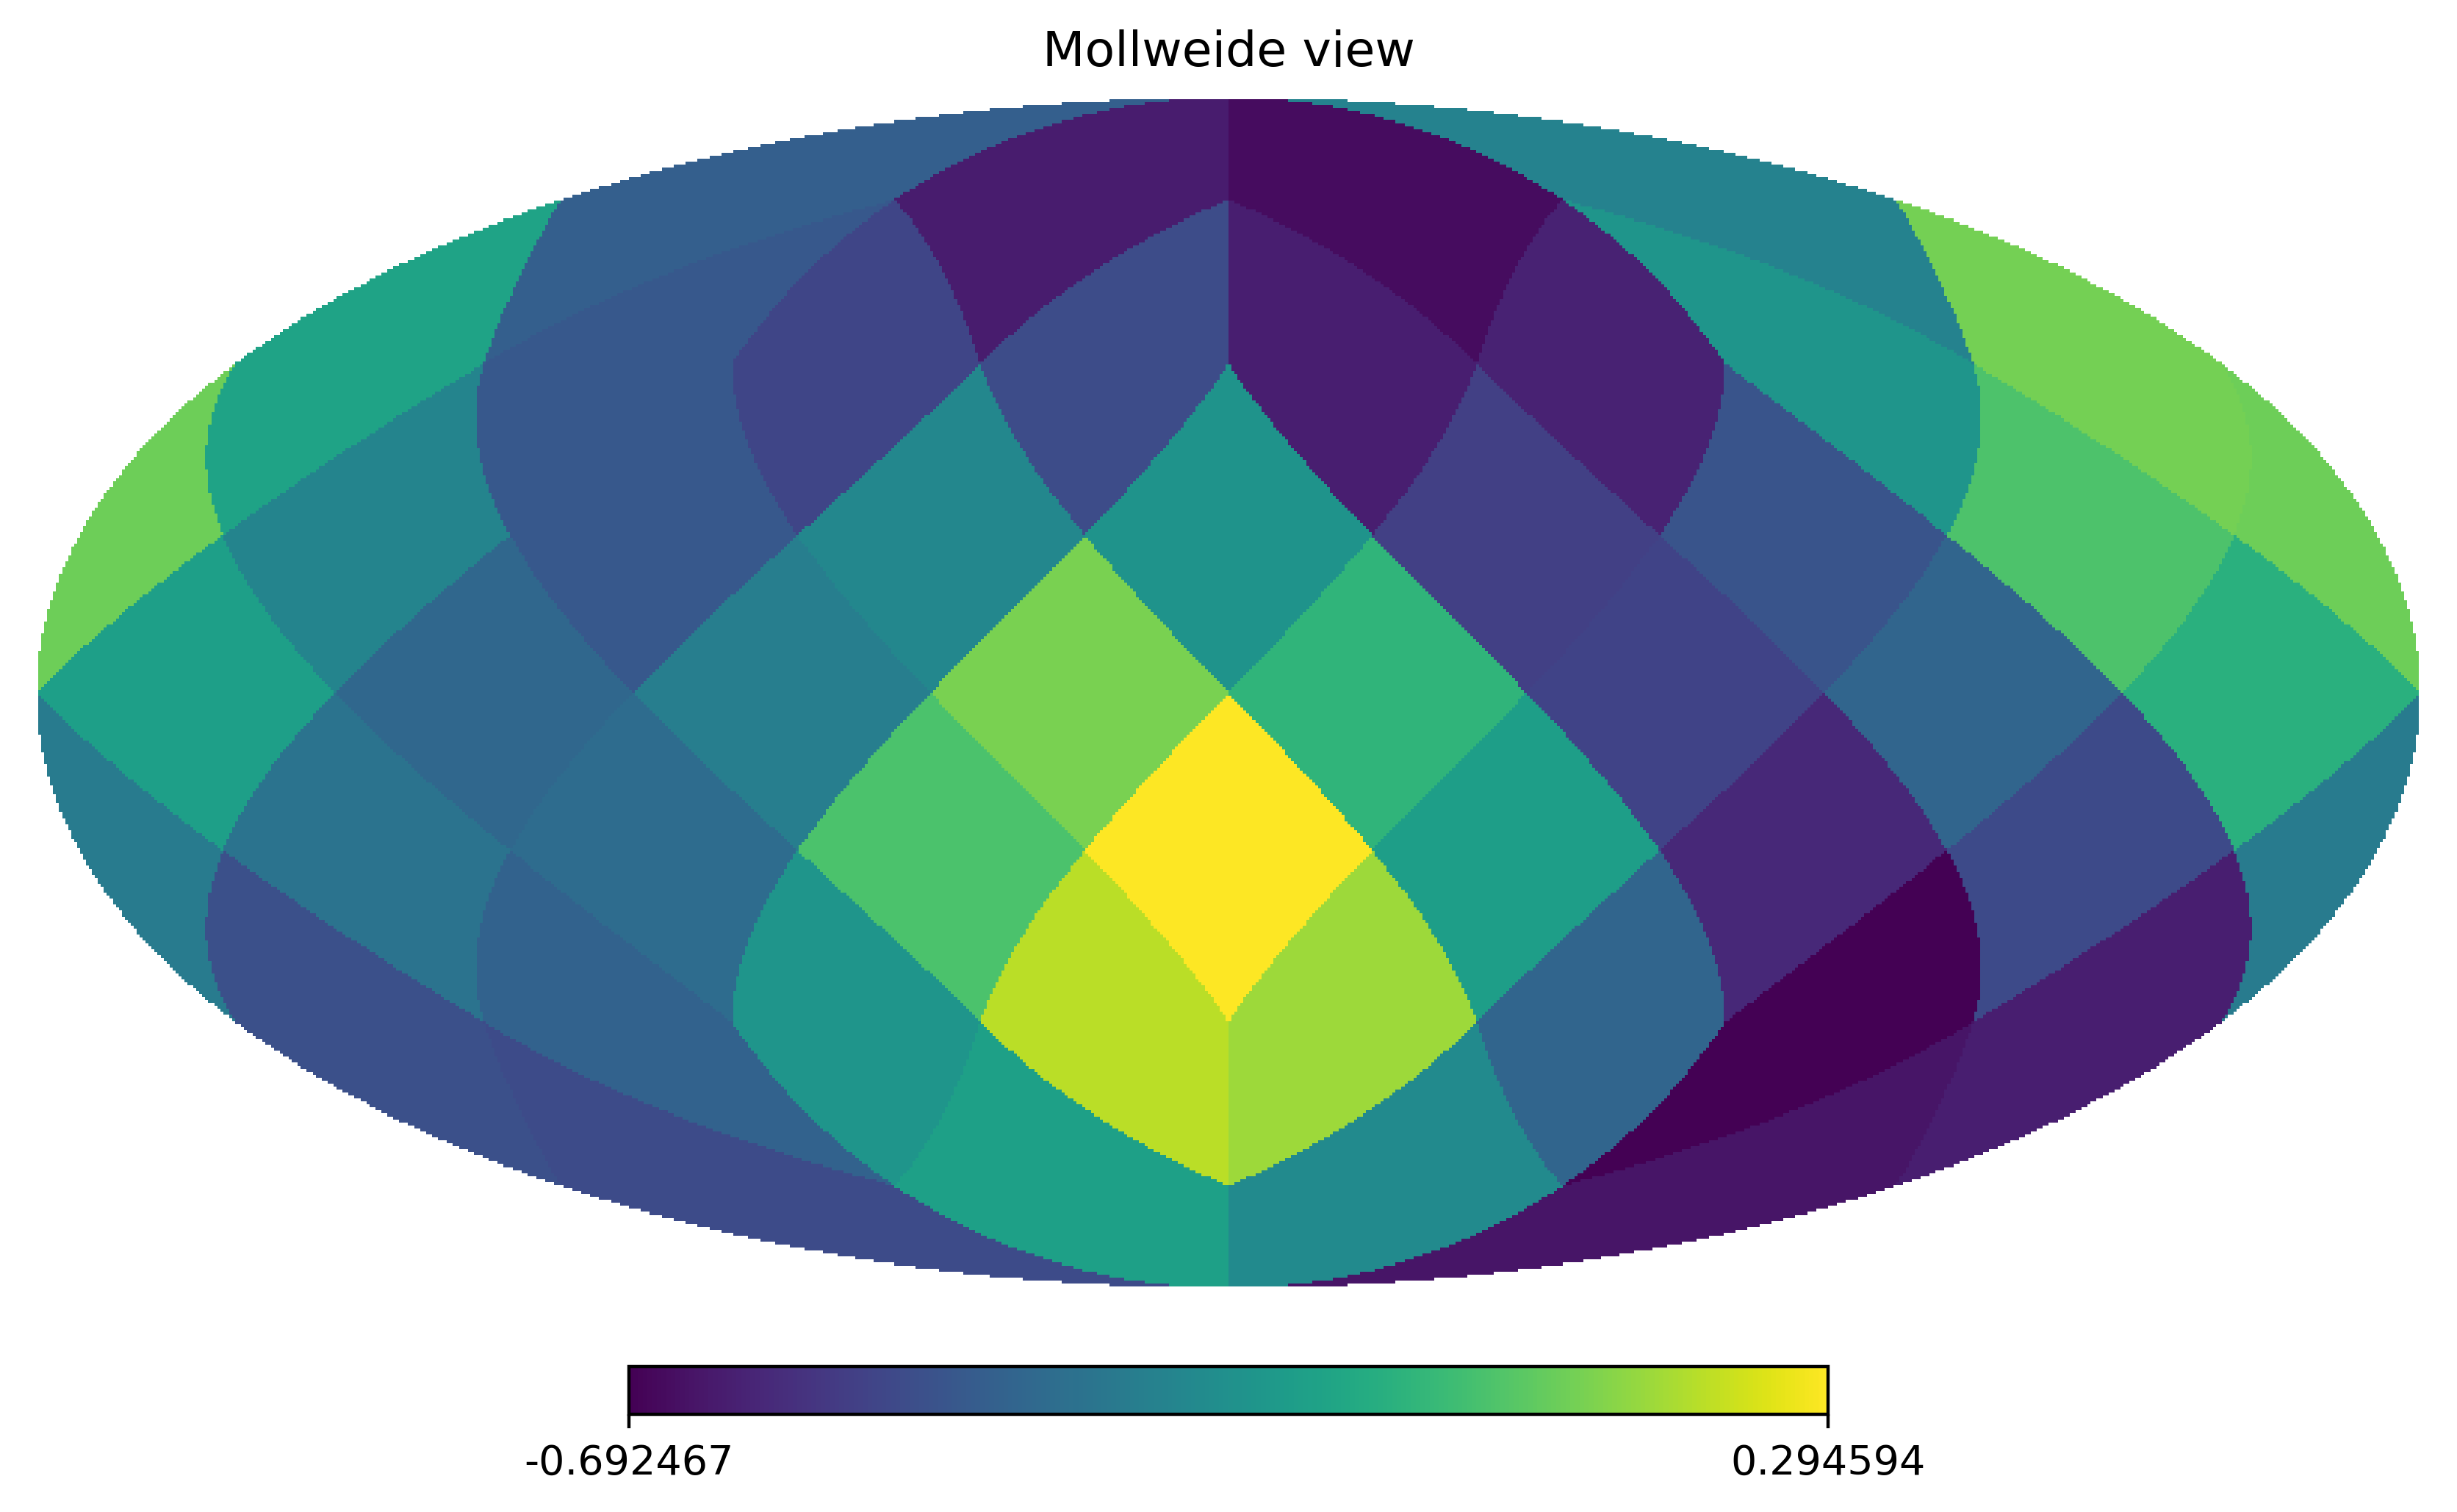

In [40]:
hp.mollview(chisel.optimum_x[0,0],nest=True)

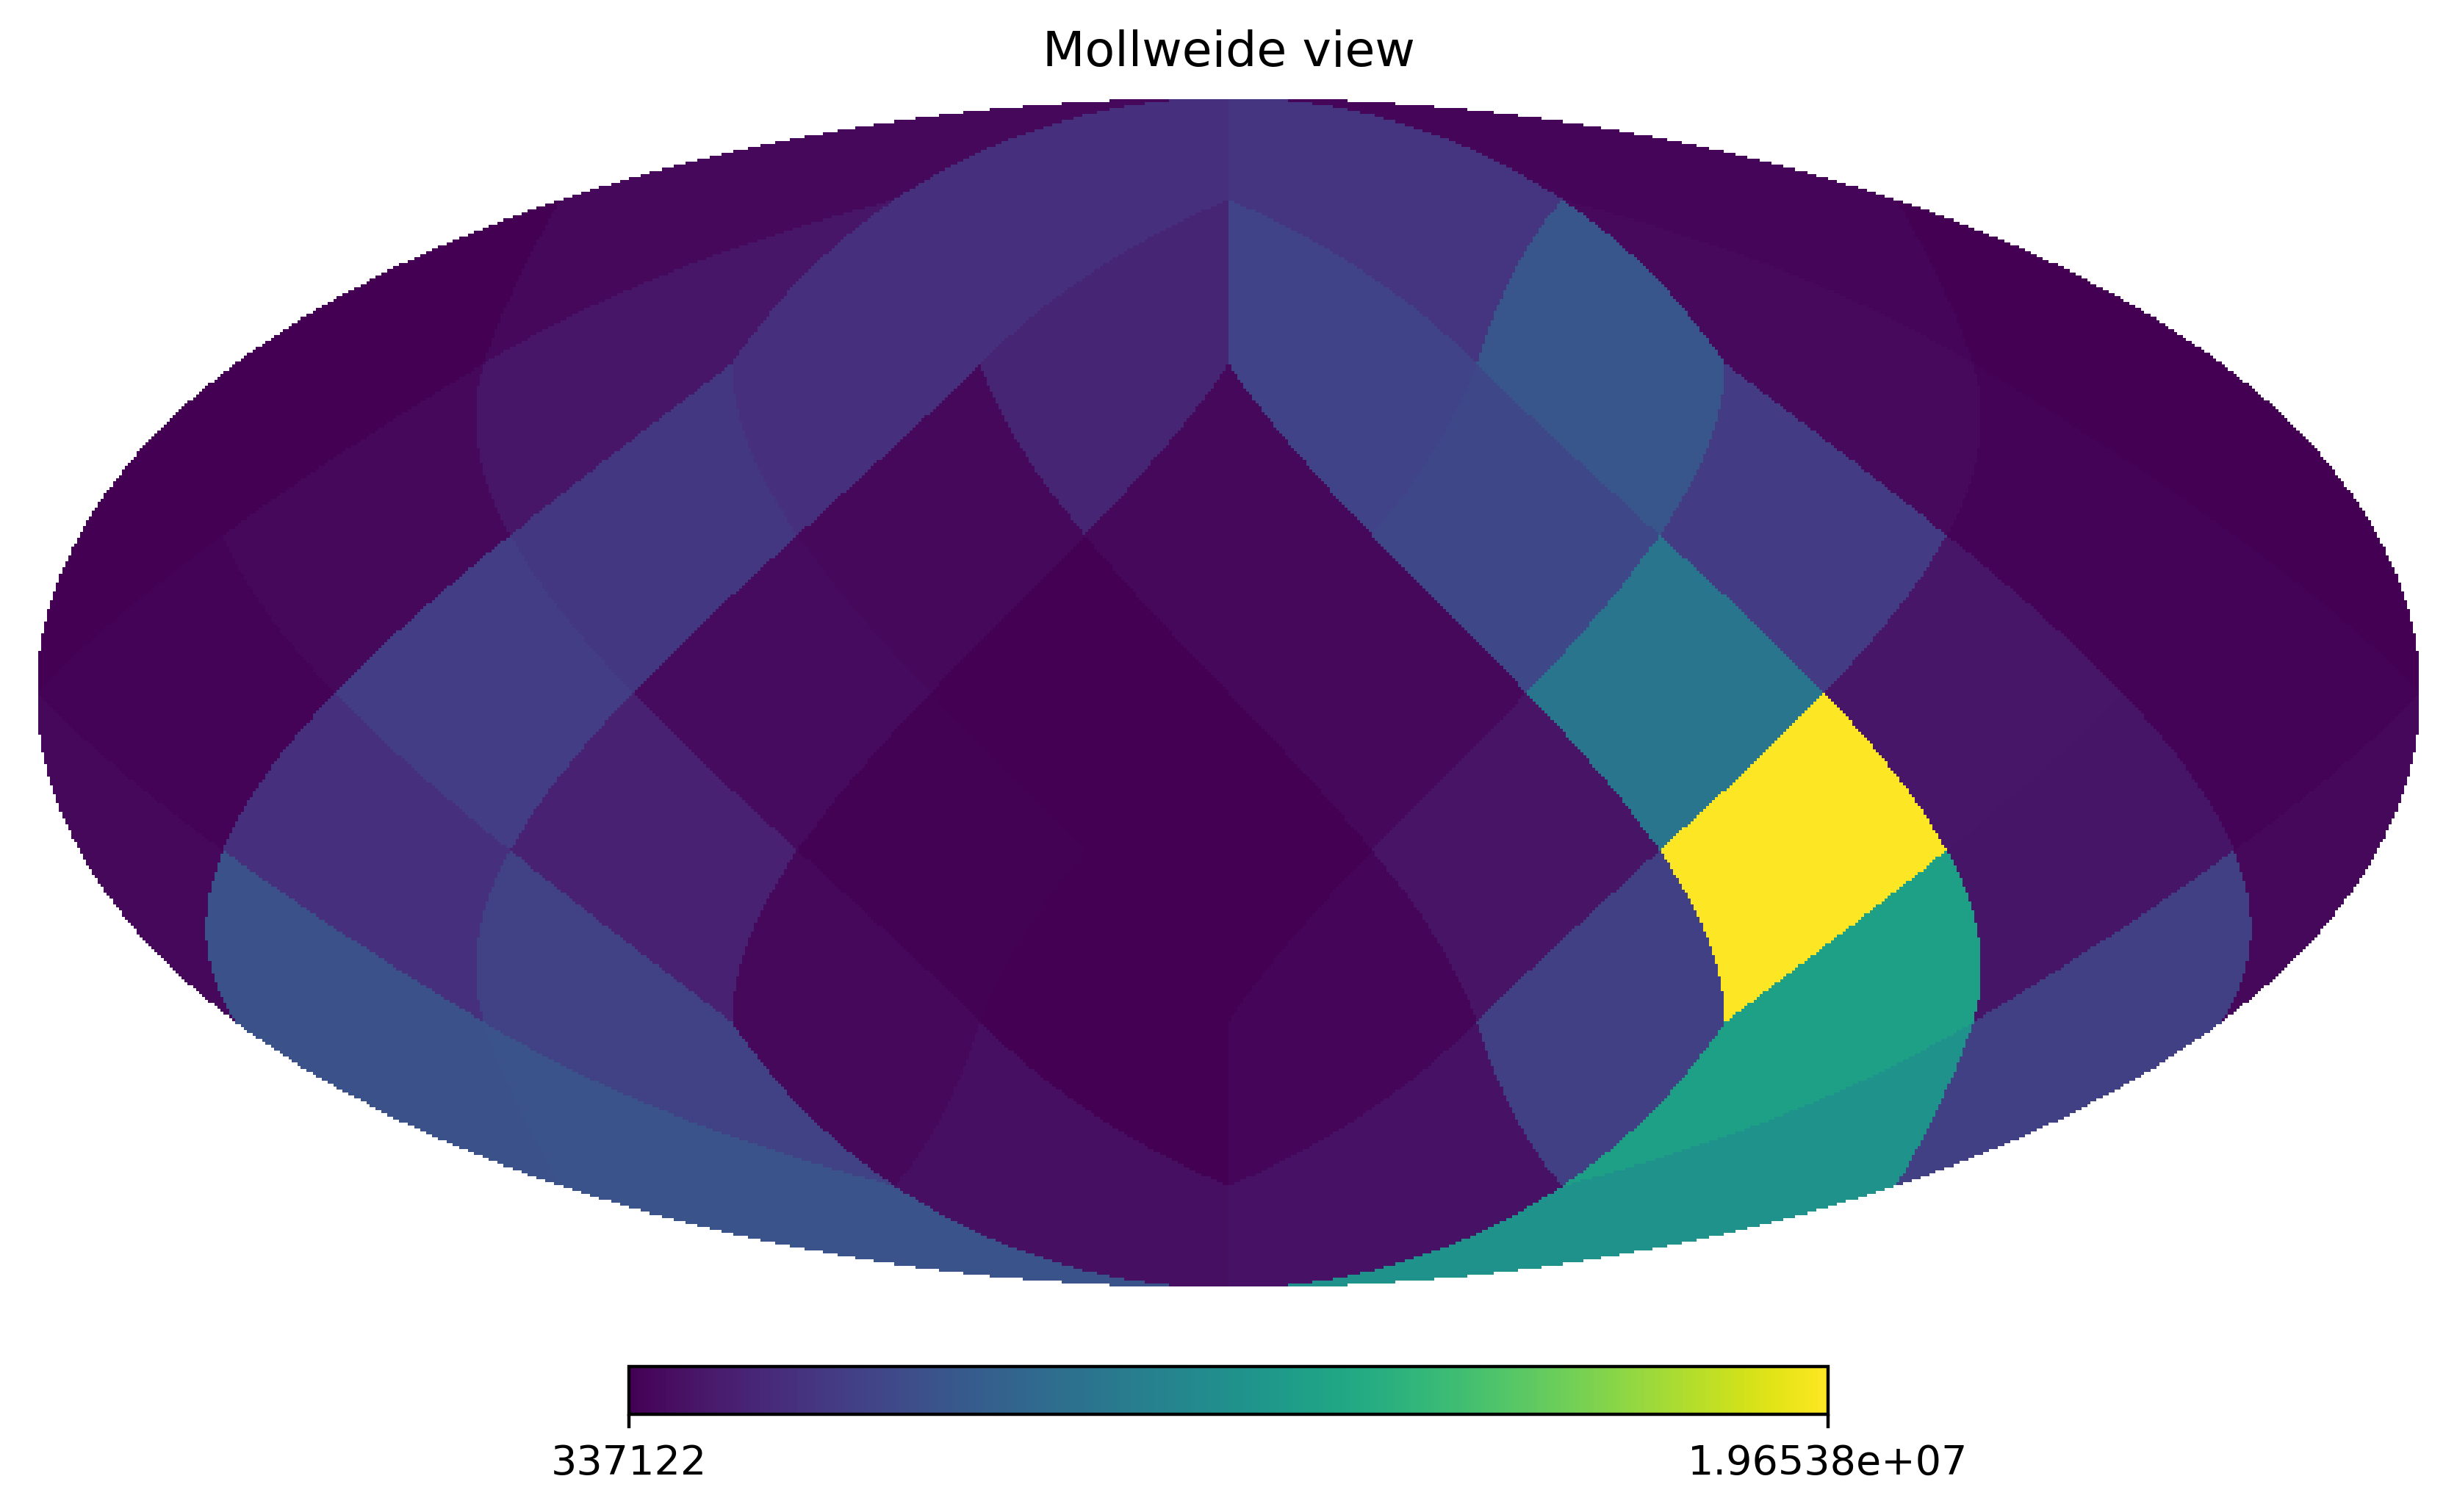

In [25]:
hp.mollview(chisel.n.sum(axis=(0,1)),nest=False)

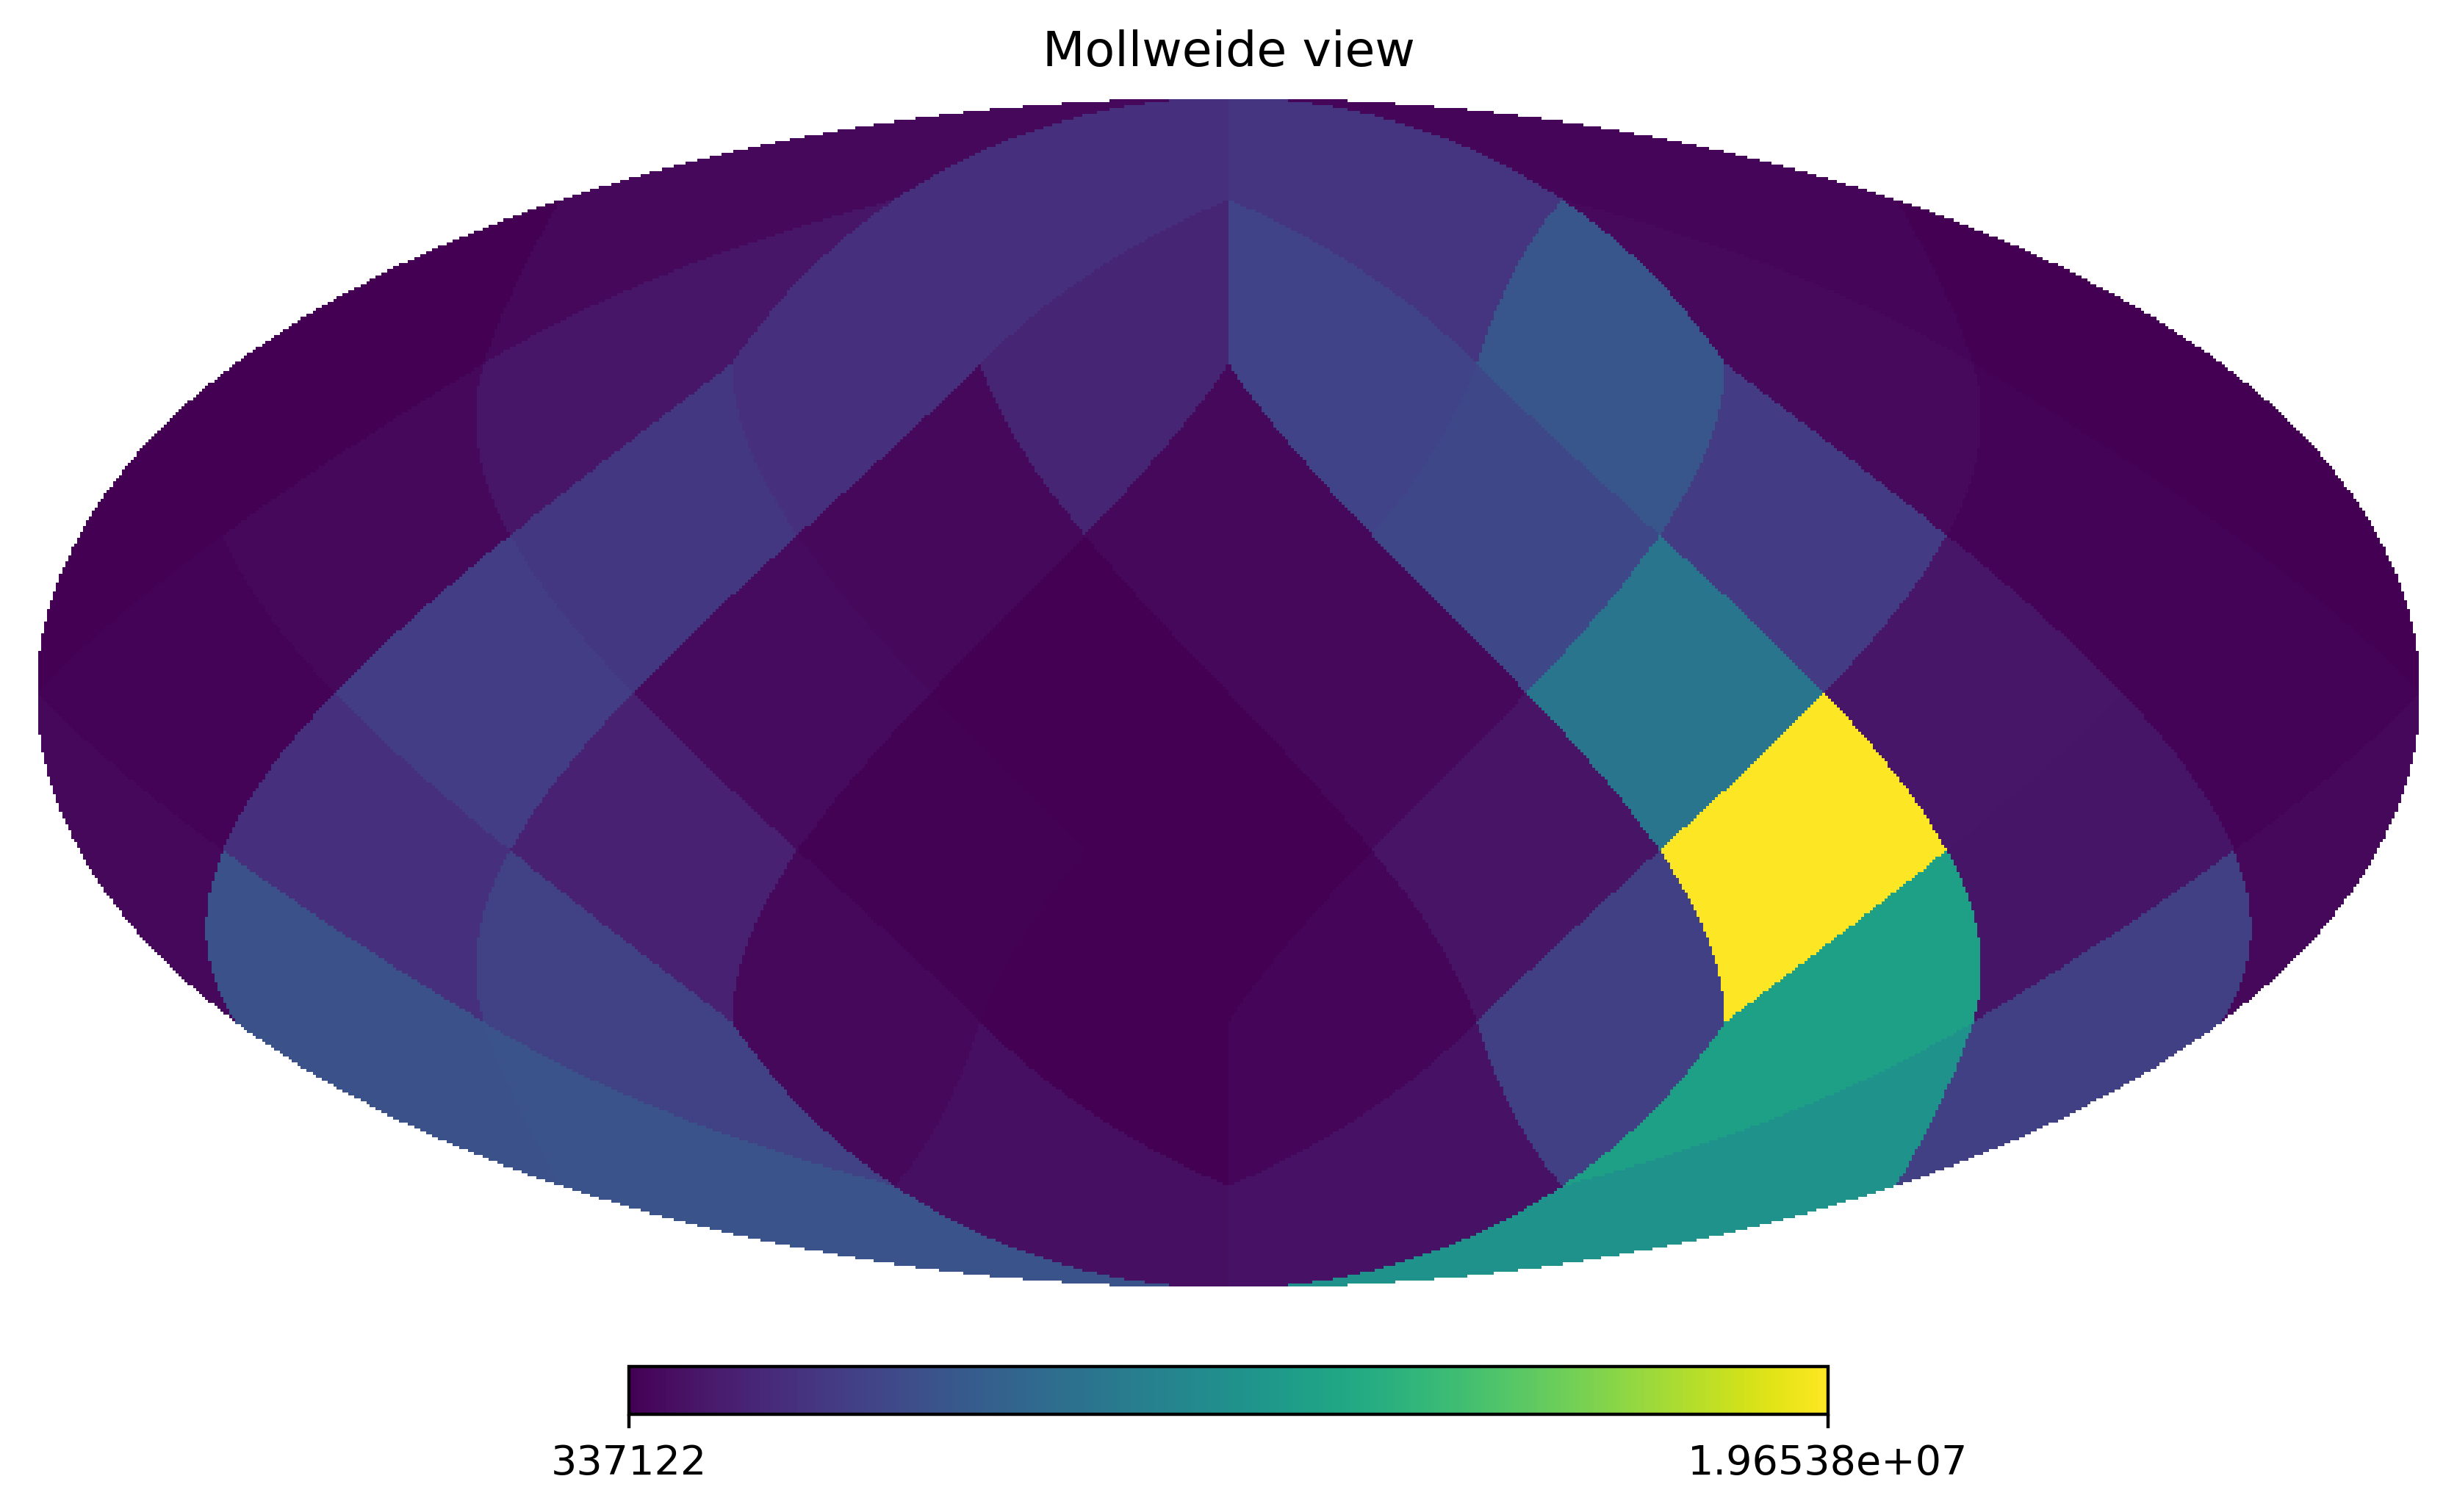

In [27]:
hp.mollview(hammer.n.sum(axis=(0,1)),nest=False)